In [1]:
import sys
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, GroupKFold, ParameterGrid, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GroupShuffleSplit
import numpy as np

project_root = Path.cwd().resolve()
sys.path.insert(0, str(project_root / "preprocessing"))
sys.path.insert(0, str(project_root / "features"))


from preprocessing.face_detection import load_and_detect_faces_jaffe, load_and_detect_faces_ck
from features.hog_features import extract_hog_features
from features.lbp_features import extract_lbp_features_blocks
from features.gabor_features import extract_gabor_features_batch


### Load datasets and detect faces

In [2]:
def jaffe_subject_id(fname: str) -> str:
    return fname[:2]   # KA, KM, YM, ...

def load_dataset(dataset="ck", jaffe_test_size=0.2, random_state=42):
    if dataset.lower() == "ck":
        X_train_images, y_train = load_and_detect_faces_ck(
            "/Users/niklioni/Desktop/Artificial Intelligence/Assessment/data/CK_dataset/train"
        )
        X_test_images, y_test = load_and_detect_faces_ck(
            "/Users/niklioni/Desktop/Artificial Intelligence/Assessment/data/CK_dataset/test"
        )
        return X_train_images, X_test_images, y_train, y_test

    elif dataset.lower() == "jaffe":
        X, y, fnames = load_and_detect_faces_jaffe(
            "/Users/niklioni/Desktop/Artificial Intelligence/Assessment/data/jaffe",
            return_filenames=True
        )

        groups = np.array([jaffe_subject_id(f) for f in fnames])

        gss = GroupShuffleSplit(
            n_splits=1,
            test_size=jaffe_test_size,
            random_state=random_state
        )
        train_idx, test_idx = next(gss.split(X, y, groups=groups))

        jaffe_training_images = [X[i] for i in train_idx]
        jaffe_test_images     = [X[i] for i in test_idx]
        jaffe_training_labels = [y[i] for i in train_idx]
        jaffe_test_labels     = [y[i] for i in test_idx]

        # WICHTIG für GroupKFold in CV:
        jaffe_train_groups = groups[train_idx]
        jaffe_test_groups  = groups[test_idx]

        print("\n=== Loaded dataset: JAFFE (PERSON-DISJOINT) ===")
        print(f"Train samples: {len(jaffe_training_images)} | Test samples: {len(jaffe_test_images)}")
        print(f"Train subjects: {len(set(jaffe_train_groups))} | Test subjects: {len(set(jaffe_test_groups))}")

        # Gib groups mit zurück:
        return (jaffe_training_images, jaffe_test_images,
                jaffe_training_labels, jaffe_test_labels,
                jaffe_train_groups, jaffe_test_groups)

    else:
        raise ValueError("dataset must be 'ck' or 'jaffe'")



### Create the sets

In [3]:
jaffe_training_images, jaffe_test_images, jaffe_training_labels, jaffe_test_labels, jaffe_train_groups, jaffe_test_groups = load_dataset("jaffe")
ck_training_images, ck_test_images, ck_training_labels,ck_test_labels = load_dataset("ck")  # CK TEST


=== Loaded dataset: JAFFE (PERSON-DISJOINT) ===
Train samples: 148 | Test samples: 36
Train subjects: 8 | Test subjects: 2


### Set the parameters

In [4]:
RANDOM_STATE = 42
GABOR_POOL = "mean_var"

GRID_PCA_COMPONENTS = [10, 20, 30, 50]
GRID_PCA_WHITEN     = [False]
GRID_SVM_C          = [0.001, 0.003, 0.01, 0.03, 0.1]

# Pipeline Linear SVM
def make_pipe():
    return Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(random_state=RANDOM_STATE)),
        ("svm", LinearSVC(
            class_weight="balanced",
            max_iter=300000,
            tol=1e-3,
            dual=False
        ))
    ])

param_grid = {
    "pca__n_components": GRID_PCA_COMPONENTS,
    "pca__whiten": GRID_PCA_WHITEN,
    "svm__C": GRID_SVM_C,
}

### Build the features and models

In [5]:
def X_hog(images):
    return extract_hog_features(images)

def X_gabor(images):
    return extract_gabor_features_batch(images, pool=GABOR_POOL)

def X_lbp(images):
    return extract_lbp_features_blocks(images)

def X_hog_gabor(images):
    return np.hstack([X_hog(images), X_gabor(images)])

def X_hog_lbp(images):
    return np.hstack([X_hog(images), X_lbp(images)])

def X_gabor_lbp(images):
    return np.hstack([X_gabor(images), X_lbp(images)])

MODELS = [
    ("HOG", X_hog),
    ("LBP", X_lbp),
    ("Gabor", X_gabor),
    ("HOG + Gabor", X_hog_gabor),
    ("HOG + LBP", X_hog_lbp),
    ("Gabor + LBP", X_gabor_lbp),
]


### Experiment function to run all of them

In [6]:
###############
# Experimente
##################
def run_all_experiments():
    results = []

    jaffe_labels = np.unique(jaffe_test_labels)
    ck_labels = np.unique(ck_test_labels)

    for name, build_X in MODELS:
        print(f"\n===== {name} =====")

        # building features
        Xtr_j = build_X(jaffe_training_images)
        Xte_j = build_X(jaffe_test_images)
        ytr_j = np.array(jaffe_training_labels)
        yte_j = np.array(jaffe_test_labels)
        gtr_j = np.array(jaffe_train_groups)

        Xtr_c = build_X(ck_training_images)
        Xte_c = build_X(ck_test_images)
        ytr_c = np.array(ck_training_labels)
        yte_c = np.array(ck_test_labels)

        #  Cross validation stuff
        cv_j = GroupKFold(n_splits=len(np.unique(gtr_j)))  # LOSO
        cv_c = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

        # Hyperparameter search
        best = None
        for params in ParameterGrid(param_grid):
            pipe = make_pipe().set_params(**params)

            cv_j_scores = cross_val_score(
                pipe, Xtr_j, ytr_j,
                cv=cv_j, groups=gtr_j,
                scoring="accuracy", n_jobs=-1
            )

            cv_c_scores = cross_val_score(
                pipe, Xtr_c, ytr_c,
                cv=cv_c,
                scoring="accuracy", n_jobs=-1
            )

            avg_cv = 0.5 * (cv_j_scores.mean() + cv_c_scores.mean())

            if best is None or avg_cv > best["avg_cv"]:
                best = {
                    "params": params,
                    "avg_cv": avg_cv,
                }

        # --- Final fit ---
        clf_j = make_pipe().set_params(**best["params"]).fit(Xtr_j, ytr_j)
        clf_c = make_pipe().set_params(**best["params"]).fit(Xtr_c, ytr_c)

        res = {
            "name": name,
            "avg_cv": best["avg_cv"],
            "params": best["params"],
            "jaffe_test_acc": accuracy_score(yte_j, clf_j.predict(Xte_j)),
            "ck_test_acc": accuracy_score(yte_c, clf_c.predict(Xte_c)),
            "jaffe_cm": confusion_matrix(yte_j, clf_j.predict(Xte_j), labels=jaffe_labels),
            "ck_cm": confusion_matrix(yte_c, clf_c.predict(Xte_c), labels=ck_labels),
            "jaffe_labels": jaffe_labels,
            "ck_labels": ck_labels,
        }

        results.append(res)

        print(f"AVG CV: {res['avg_cv']:.4f}")
        print(f"JAFFE Test Acc: {res['jaffe_test_acc']:.4f}")
        print(f"CK    Test Acc: {res['ck_test_acc']:.4f}")

    return results


results = run_all_experiments()



===== HOG =====
AVG CV: 0.6745
JAFFE Test Acc: 0.6389
CK    Test Acc: 0.6783

===== LBP =====
AVG CV: 0.5835
JAFFE Test Acc: 0.4444
CK    Test Acc: 0.5664

===== Gabor =====
AVG CV: 0.4579
JAFFE Test Acc: 0.3333
CK    Test Acc: 0.3846

===== HOG + Gabor =====
AVG CV: 0.6822
JAFFE Test Acc: 0.6389
CK    Test Acc: 0.6783

===== HOG + LBP =====
AVG CV: 0.6647
JAFFE Test Acc: 0.7222
CK    Test Acc: 0.6783

===== Gabor + LBP =====
AVG CV: 0.5713
JAFFE Test Acc: 0.5000
CK    Test Acc: 0.5455


## Confusion Matrix

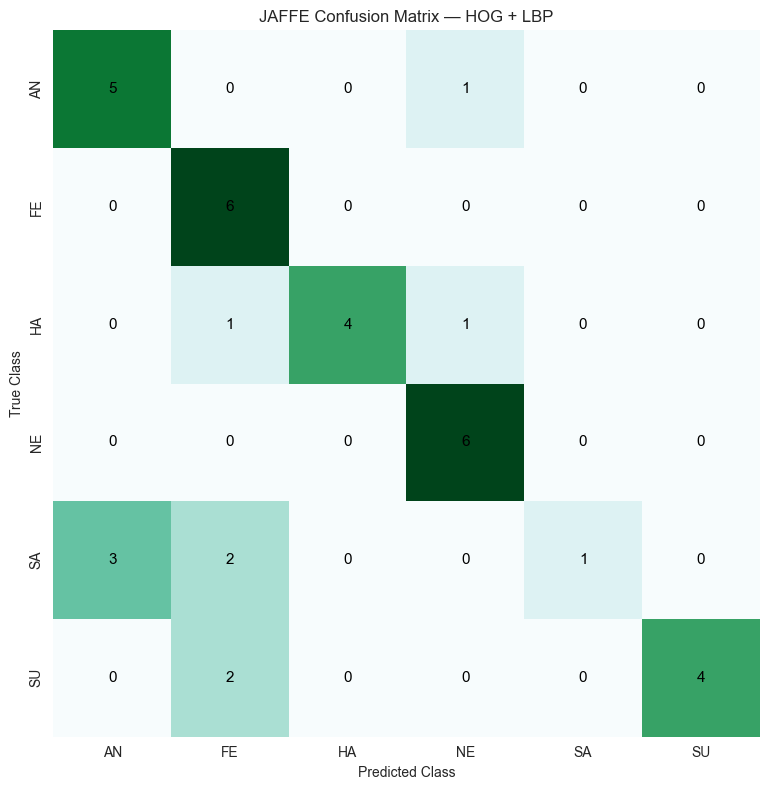

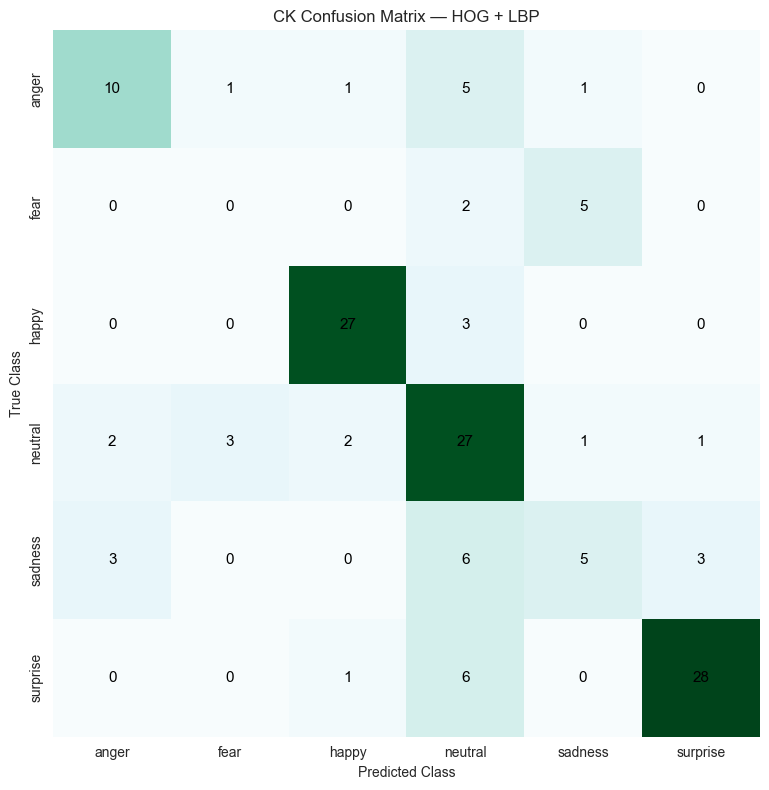

In [7]:
hog_lbp = next(r for r in results if r["name"] == "HOG + LBP")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix_seaborn(cm, class_names, title):
    plt.figure(figsize=(8, 8))

    ax = sns.heatmap(
        cm,
        annot=False,
        cmap="BuGn",
        xticklabels=class_names,
        yticklabels=class_names,
        cbar=False,
        square=True
    )

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j + 0.5,
                i + 0.5,
                f"{cm[i, j]}",
                ha="center",
                va="center",
                fontsize=11,
                color="black"
            )

    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_confusion_matrix_seaborn(
    hog_lbp["jaffe_cm"],
    hog_lbp["jaffe_labels"],
    "JAFFE Confusion Matrix — HOG + LBP"
)

plot_confusion_matrix_seaborn(
    hog_lbp["ck_cm"],
    hog_lbp["ck_labels"],
    "CK Confusion Matrix — HOG + LBP"
)
